In [1]:
import math
import random

import time
import logging

from dataclasses import dataclass

import numpy as np
import scipy.stats

%matplotlib notebook
import matplotlib.pyplot as plt

In [2]:
@dataclass
class Obstacle: 
    orientation: tuple # x, y, angle (angle of front face normal to axis)
    size: tuple # length , width
    faces: tuple # ID of face going counter clockwise from 'front' face

In [3]:
obs = [
    Obstacle((-0.16, 0.42, 0.0), (0.1, 0.1), (1,0,0,0)),
    Obstacle((-0.04, 0.59, math.pi/4), (0.1, 0.1), (1,0,0,0)),
    Obstacle((0.14, 0.5, 0), (0.1, 0.1), (1,0,0,0)),
    ]

In [4]:
def rotationMatrix2d(angles): #Homogeneous
    N = len(angles)
    cT = np.cos(angles)
    sT = np.sin(angles)
    rotM = np.transpose(np.stack([
        [cT, -sT, np.zeros(N)],
        [sT, cT, np.zeros(N)],
        [np.zeros(N), np.zeros(N), np.ones(N)]
    ]), [2,0,1])
    return rotM

In [5]:
def forwardVector(angles):
    return np.transpose(np.array([[np.cos(angles)], [np.sin(angles)]]), [2,0,1])

In [6]:
class Map(object):
    def __init__(self, obstacles):
        self.obstacles = obstacles
        
        self.facesId = []
        self.facesFrame = []
        self.facesAngle = []
        
        for o in obstacles:
            
            x,y,a = o.orientation
            l,w = o.size #length , width
            cA = math.cos(a)
            sA = math.sin(a)
            
            facesAngle = np.fmod(np.array([0, math.pi/2, math.pi, 3*math.pi/2]) + a,2*math.pi)
            facesAngle[facesAngle >= math.pi/2] = facesAngle[facesAngle >= math.pi/2] - 2*math.pi
            
            ids = np.array(list(o.faces))
            base = rotationMatrix2d(facesAngle)
            
            origins = np.zeros((4,3,1), dtype=float)
            origins[:,2] = 1.0
            
            origins = np.matmul(np.array([
                [[1, 0, l/2],
                 [0, 1, 0],
                 [0, 0, 1]],
                [[1, 0, 0],
                 [0, 1, w/2],
                 [0, 0, 1]],
                [[1, 0, -l/2],
                 [0, 1, 0],
                 [0, 0, 1]],
                [[1, 0, 0],
                 [0, 1, -w/2],
                 [0, 0, 1]],
            ]), origins)
            
            origins = np.matmul(np.array([
                [cA, -sA, x],
                [sA, cA, y],
                [0.0, 0.0, 1.0]
            ]), origins)

            base[:,:2,2] = origins[:,:2,0]
            self.facesId.append(ids)
            self.facesFrame.append(base)
            self.facesAngle.append(facesAngle)
        self.facesId = np.concatenate(self.facesId)
        self.facesFrame = np.concatenate(self.facesFrame)
        self.facesAngle = np.concatenate(self.facesAngle)
    
    def plotKeypoints(self, xlim=(0, 2.0), ylim=(0, 2.0), quiverScale=20):
        fig = plt.figure()
        
        #Points
        points = self.facesFrame[:, :2, 2]
        pointsLabels = self.facesId[:]
        plt.scatter(points[:,0], points[:,1])
        
        # x
        plt.quiver(points[:,0], points[:,1], self.facesFrame[:,0,0], self.facesFrame[:,1,0], color=[(1,0,0,1)], scale=quiverScale)
        
        # y
        plt.quiver(points[:,0], points[:,1], self.facesFrame[:,0,1], self.facesFrame[:,1,1], color=[(0,1,0,1)], scale=quiverScale)
        
        for i,faceId in enumerate(self.facesId):
            plt.annotate(faceId, (points[i,0], points[i,1]))
            
        plt.axis('equal')
        plt.xlim(xlim)
        plt.ylim(ylim)
        plt.gca().set_autoscale_on(False)
        plt.grid()
        
        
        return fig
    
    def getRelativePoints(self, detectId, detectOrientation):
        # detectOrientation = [x,y,angle] #angle is angle of normal of sign saw by camera
        
        detectMask = self.facesId == detectId
        
        relPoints = np.matmul(self.facesFrame[detectMask], np.array([[[detectOrientation[0]], [detectOrientation[1]], [1.0]]]))
        facing = self.facesAngle[detectMask].reshape(-1,1,1) - detectOrientation[2] + math.pi
        facing[facing >= math.pi] = facing[facing >= math.pi] - 2*math.pi
        
        return np.concatenate([relPoints[:,:2], facing], axis=1)
        
        

In [7]:
def plotPose(poses, color=(1,1,0,1)):
    # poses = [[[x],[y],[angle]], [[x],[y],[angle]]]
    
    plt.scatter(poses[:,0,0], poses[:,1,0], color=color)
    
    forVec = forwardVector(poses[:,2,0])
    #print(forVec.shape)
    
    plt.quiver(poses[:,0,0], poses[:,1,0], forVec[:,0,0], forVec[:,1,0], color=[color])
    

In [8]:
robotMap = Map(obs)

<IPython.core.display.Javascript object>


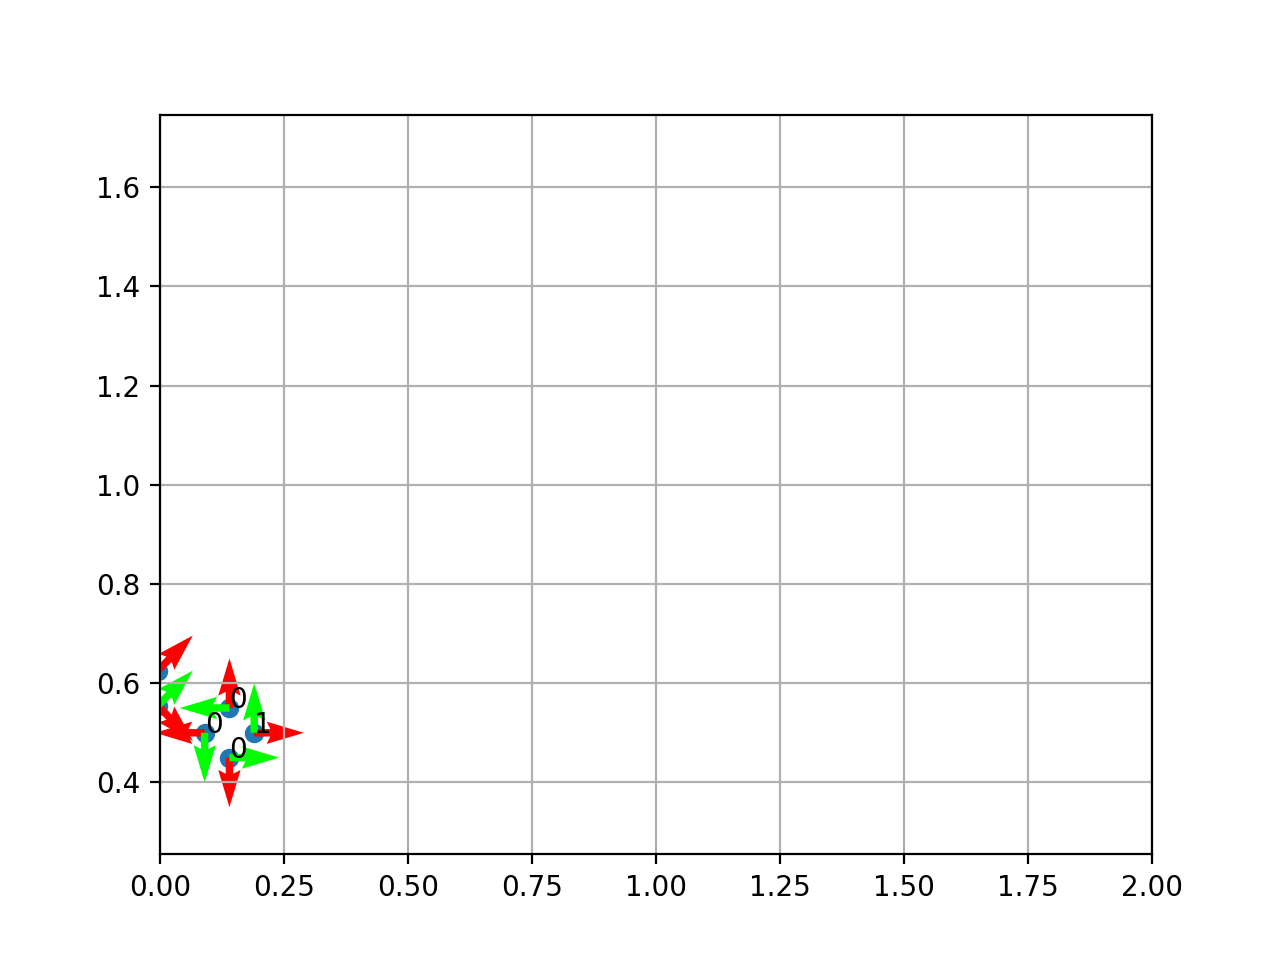

In [9]:
fig1 = robotMap.plotKeypoints(quiverScale=20)

In [10]:
robotMap.facesAngle

array([ 0.        , -4.71238898, -3.14159265, -1.57079633,  0.78539816,
       -3.92699082, -2.35619449, -0.78539816,  0.        , -4.71238898,
       -3.14159265, -1.57079633])

In [11]:
relPoses = robotMap.getRelativePoints(0, [0.2, 0.0, 0.0])

In [12]:
relPoses

array([[[-0.16      ],
        [ 0.67      ],
        [-1.57079633]],

       [[-0.41      ],
        [ 0.42      ],
        [ 0.        ]],

       [[-0.16      ],
        [ 0.17      ],
        [ 1.57079633]],

       [[-0.2167767 ],
        [ 0.7667767 ],
        [-0.78539816]],

       [[-0.2167767 ],
        [ 0.4132233 ],
        [ 0.78539816]],

       [[ 0.1367767 ],
        [ 0.4132233 ],
        [ 2.35619449]],

       [[ 0.14      ],
        [ 0.75      ],
        [-1.57079633]],

       [[-0.11      ],
        [ 0.5       ],
        [ 0.        ]],

       [[ 0.14      ],
        [ 0.25      ],
        [ 1.57079633]]])

<IPython.core.display.Javascript object>


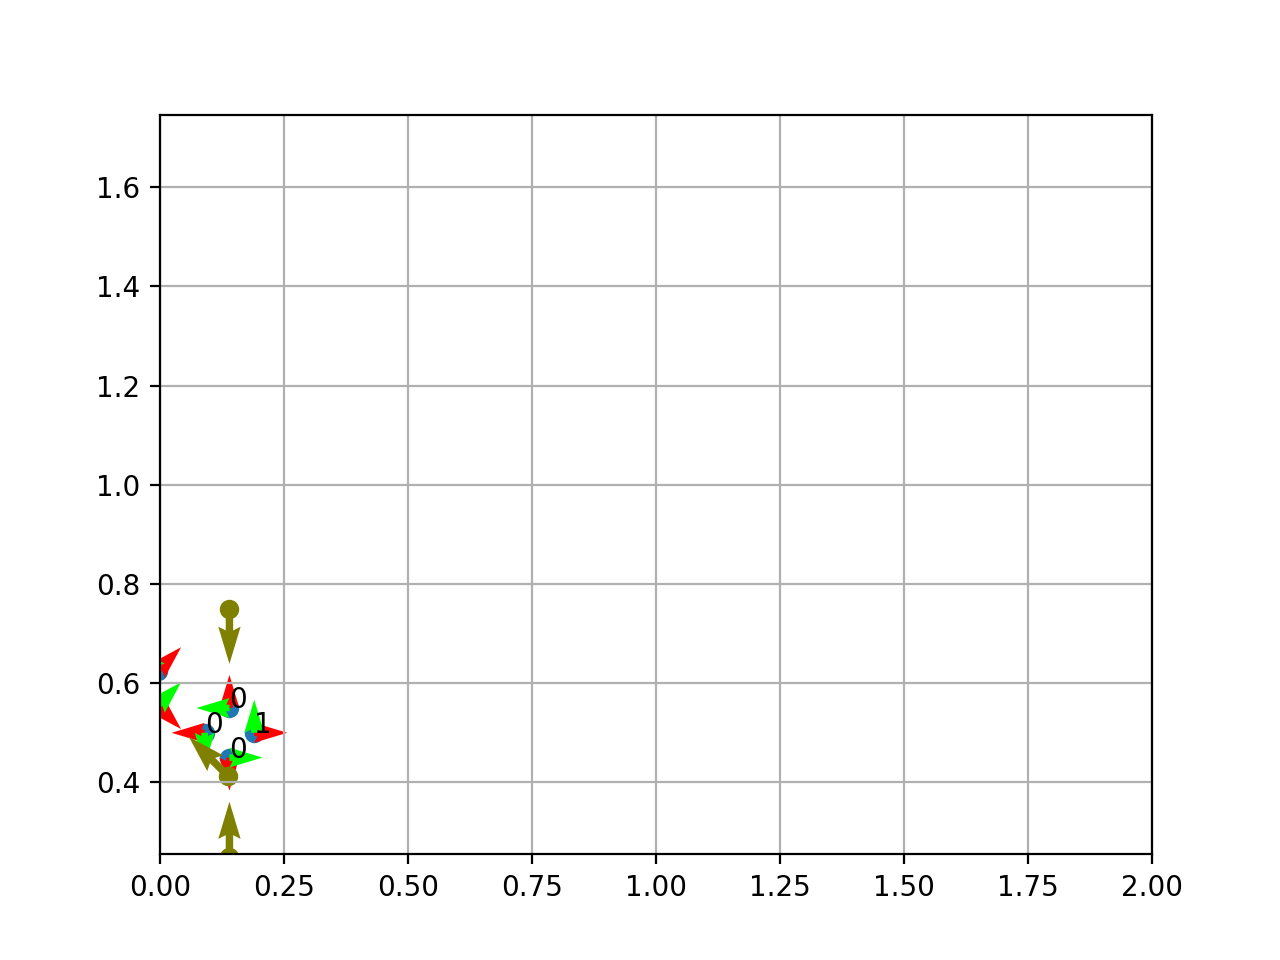

In [13]:
fig2 = robotMap.plotKeypoints(quiverScale=30)
plotPose(relPoses,color=(0.5,0.5,0,1))

In [14]:
relPoses2 = robotMap.getRelativePoints(0, [0.2, 0.1, -math.pi/8])

<IPython.core.display.Javascript object>


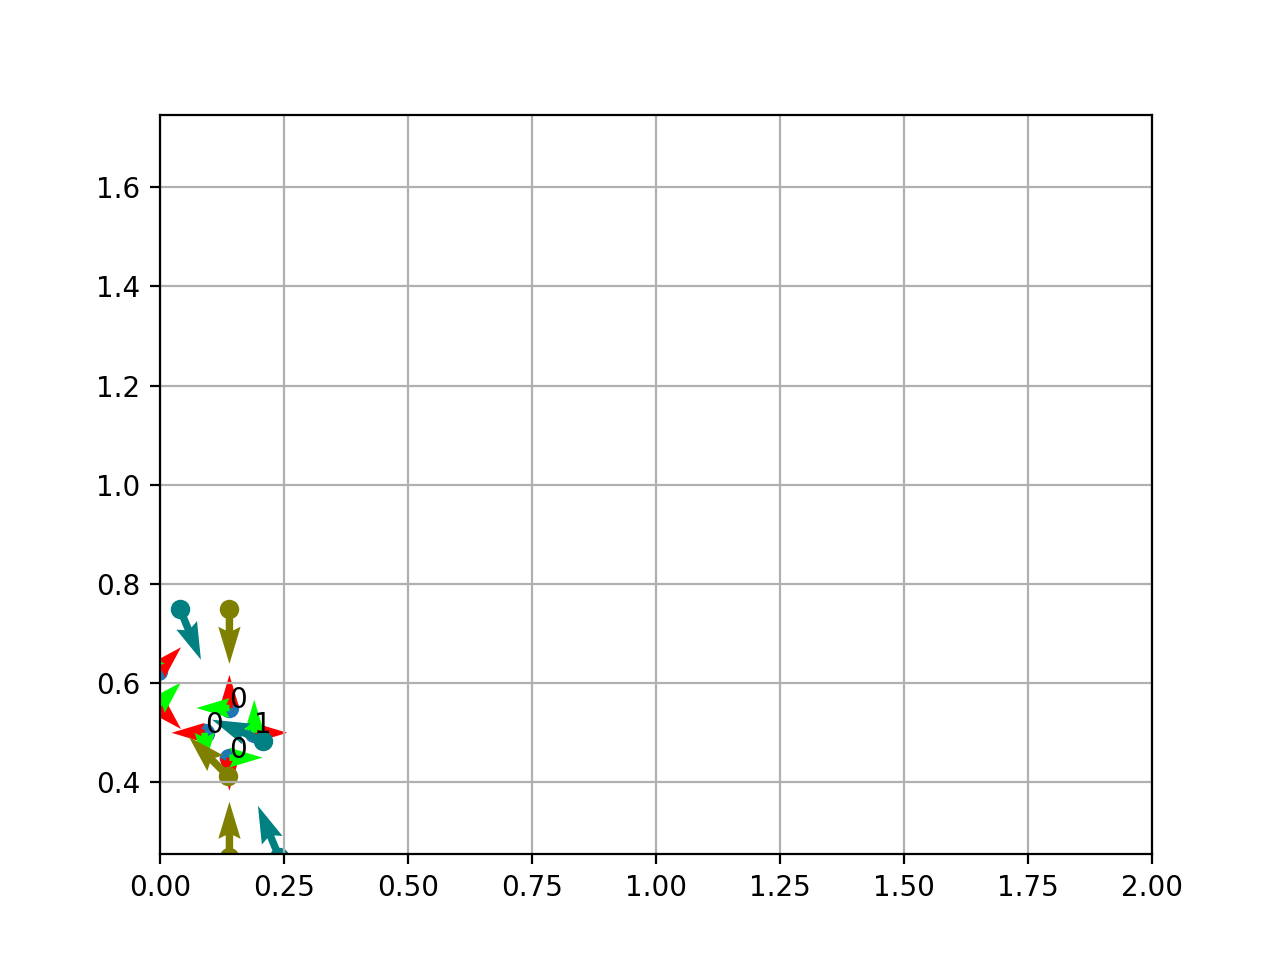

In [15]:
fig3 = robotMap.plotKeypoints(quiverScale=30)
plotPose(relPoses,color=(0.5,0.5,0,1))
plotPose(relPoses2,color=(0.0,0.5,0.5,1))

In [16]:
def relPoseNormPdf(relPoses, relPosesStd, orientations, resolution=np.array([[[0.0001],[0.0001],[0.01*math.pi/180]]])):
    # K Keypoints
    # P particles
    # relPoses = (K,3,1)
    # relPosesStd = (K,3,1)
    # orientations = (1,3,P)
    
    #print(relPoses.shape)
    #print(relPosesStd.shape)
    #print(orientations.shape)
    
    posDist = scipy.stats.norm(loc=relPoses[:,:2], scale=relPosesStd[:,:2])
    angleDist = scipy.stats.norm(loc=np.expand_dims(relPoses[:,2],-1), scale=np.expand_dims(relPosesStd[:,2],-1))
    
    angles = orientations[0,2,:] + np.array([[[2*math.pi],[0.0],[-2*math.pi]]])
    
    # Using cdf
    posProb = posDist.cdf(orientations[0,:2,:]+resolution[0,:2]/2) - posDist.cdf(orientations[0,:2,:]-resolution[0,:2]/2)
    angleProb = np.max(np.abs(angleDist.cdf(angles+resolution[0,2,0]/2) - angleDist.cdf(angles-resolution[0,2,0]/2)), axis=1)
    
    # Using pdf (probably wrong)
    # posProb = posDist.pdf(orientations[0,:2,:])
    # angleProb = np.max(angleDist.pdf(angles), axis=1)
    
    prob = np.concatenate([posProb, np.expand_dims(angleProb,1)], axis=1)
    return prob
    

In [17]:
relPoseNormPdf(relPoses, np.array([[[0.05], [0.05], [10*math.pi/180]]]), np.array([[[0.5,0.5],[0.75,0.25],[10*math.pi/180, -15*math.pi/180]]]))

array([[[0.00000000e+000, 0.00000000e+000],
        [2.21841727e-004, 3.80220716e-019],
        [6.44744130e-151, 3.33066907e-016]],

       [[0.00000000e+000, 0.00000000e+000],
        [2.77333712e-013, 2.46444267e-006],
        [2.41970725e-004, 1.29517602e-004]],

       [[0.00000000e+000, 0.00000000e+000],
        [0.00000000e+000, 2.21841727e-004],
        [5.05228435e-018, 4.57539642e-028]],

       [[0.00000000e+000, 0.00000000e+000],
        [7.54211081e-004, 5.07658076e-027],
        [1.07697740e-010, 4.43184989e-006]],

       [[0.00000000e+000, 0.00000000e+000],
        [1.12354570e-013, 3.87132218e-006],
        [8.72683104e-007, 6.07589171e-012]],

       [[2.77555756e-015, 2.77555756e-015],
        [1.12354570e-013, 3.87132218e-006],
        [4.69522573e-038, 5.53076117e-053]],

       [[4.44089210e-015, 4.44089210e-015],
        [7.97884428e-004, 1.53894512e-025],
        [6.44744130e-151, 3.33066907e-016]],

       [[0.00000000e+000, 0.00000000e+000],
        [2.9734509

In [18]:
def scaleDistribution(dist):
    return dist / np.sum(dist,0)

In [19]:
class ParticleFilter(object):

    def __init__(self, N, particles):
        self.N = N
        self.setParticles(particles)
        self.initWeight()
    
    def initWeight(self): 
        self.weights = np.ones(self.N)/N
    
    def setParticles(self, particles):
        self.particles = particles

    def resample(self): 
        index = np.random.choice(self.N, p=self.weights, size=self.N)
        self.particles = self.particles[:,index]
        self.initWeight()
        
    def neff(self):
        return 1.0/np.sum(np.power(self.weights,2))
    
    def checkAndResample(self, neffHigh):
        
        if(self.neff() < neffHigh):
            self.resample()
    
    def predict(self, movement, movementStd):
        # movement = [x, y, angle] relative to starting point of particle
        
        rotM = rotationMatrix2d(self.particles[2,:])
        self.particles += np.matmul(rotM, (np.random.normal(loc=movement, scale=movementStd)).ravel()).T
        
    def update(self, kpRelPoses, kpRelPosesStd, resolution=np.array([[[0.0001],[0.0001],[0.01*math.pi/180]]])):
        # len = number of symbols seen in image
        # kpRelPoses = [ relPoses0, relPoses1, ... ]
        # kpRelPosesStd = [ [xStd0, yStd0, angleStd0], [xStd1, yStd1, angleStd1] ]
        
        for i in range(len(kpRelPoses)):
            probs = relPoseNormPdf(kpRelPoses[i], kpRelPosesStd[i], np.expand_dims(self.particles,0), resolution=resolution)
            combinedProb = np.sum(probs, axis=0) / len(kpRelPoses[i])
            self.weights = np.multiply(self.weights, np.product(combinedProb, axis=0))
        
        self.weights = self.weights + 1e-300
        self.weights = self.weights / np.sum(self.weights)
        
    def getCurrentEstimate(self):
        
        pos = self.particles
        mean = np.sum(np.multiply(self.weights, self.particles), axis=1)
        var = np.sum(np.multiply(self.weights, np.power(pos - np.expand_dims(mean,-1),2)), axis=1)
        return mean, var
        

In [20]:
def gaussianParticles(mean, std, N):
    return np.random.normal(mean, std, N)

In [21]:
N = 1000

In [27]:
x0 = np.array([[0.1],[0.1],[math.pi/2]])
x0Std = np.array([[0.05],[0.05],[5 * math.pi/180]])

In [28]:
pf = ParticleFilter(N, np.random.normal(x0, x0Std, (x0.shape[0],N)))

In [29]:
pf.particles.shape

(3, 1000)

In [30]:
def plotParticles(particles, xlim=[0,2], ylim=[0,2]):
    fig = plt.figure()
    plt.scatter(particles[0], particles[1])
    
    headingArrow = np.array([np.cos(particles[2]),np.sin(particles[2])])
    plt.quiver(particles[0], particles[1], headingArrow[0], headingArrow[1])
    
    plt.xlim(xlim)
    plt.ylim(ylim)
    
    return fig

<IPython.core.display.Javascript object>


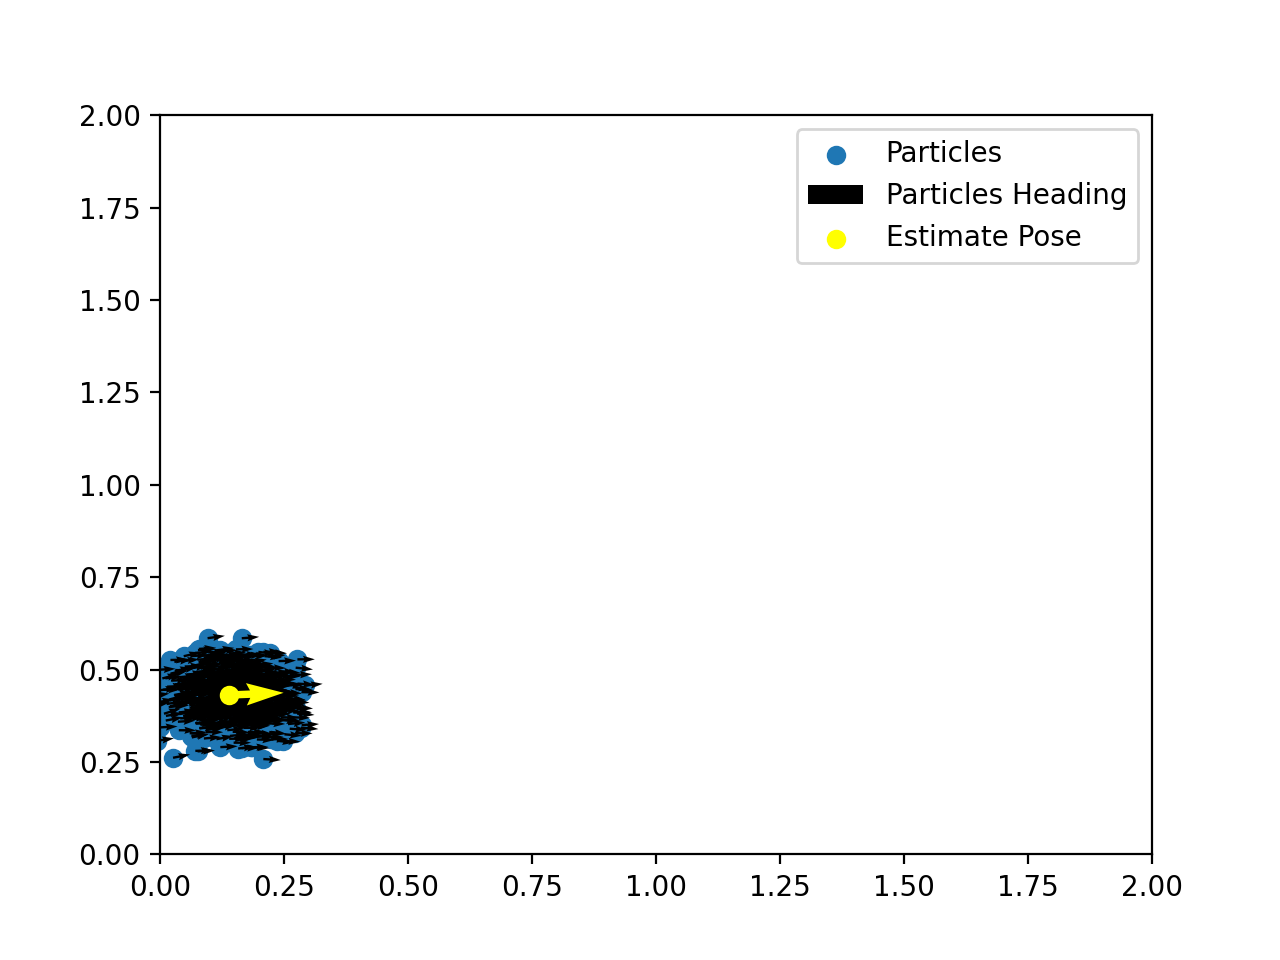

In [46]:
fig3 = plotParticles(pf.particles)
curEst, curEstVar = pf.getCurrentEstimate()
plotPose(np.expand_dims(np.expand_dims(curEst,0),-1))
plt.legend(["Particles", "Particles Heading", "Estimate Pose"])

In [43]:
movement = np.array([[0.0], [0], [-math.pi/2]])
#movement = np.array([[0.15], [0], [0.0]])

In [44]:
movementStd = np.array([[0.05],[0.05],[2*math.pi/180]])

In [45]:
rotM = pf.predict(movement,movementStd)

In [214]:
pf.particles

array([[3.79682626e-06, 5.24886897e-02, 8.51790309e-02, ...,
        1.89332328e-02, 5.07382517e-02, 7.32341727e-02],
       [2.63855972e-01, 3.03269922e-01, 3.55118180e-01, ...,
        2.16699409e-01, 1.69632942e-01, 2.46359996e-01],
       [1.55936808e+00, 1.59090019e+00, 1.48803654e+00, ...,
        1.50257820e+00, 1.56553543e+00, 1.54441528e+00]])

In [39]:
pf.update([relPoses], [np.array([[[0.05], [0.05], [10*math.pi/180]]])])

In [53]:
pf.getCurrentEstimate()

(array([0.09991875, 0.10081111, 1.61414196]),
 array([0.00243571, 0.00242189, 0.79565028]))

In [217]:
np.max(pf.weights)*pf.N

32.85017601175611

In [219]:
pf.N

1000

In [41]:
pf.neff()

317.91165534685507

In [42]:
pf.chechAndResample(pf.N/2)

In [202]:
pf.weights.shape

(1000,)

In [48]:
np.matmul(rotationMatrix2d(relPoses[:,2,0]) , np.array([[-0.097],[0.0],[0.0]]))

array([[[-5.93953698e-18],
        [ 9.70000000e-02],
        [ 0.00000000e+00]],

       [[-9.70000000e-02],
        [ 0.00000000e+00],
        [ 0.00000000e+00]],

       [[-5.93953698e-18],
        [-9.70000000e-02],
        [ 0.00000000e+00]],

       [[-9.70000000e-02],
        [ 0.00000000e+00],
        [ 0.00000000e+00]],

       [[-5.93953698e-18],
        [-9.70000000e-02],
        [ 0.00000000e+00]],

       [[ 9.70000000e-02],
        [ 1.18790740e-17],
        [ 0.00000000e+00]],

       [[ 6.85893578e-02],
        [-6.85893578e-02],
        [ 0.00000000e+00]],

       [[ 6.85893578e-02],
        [ 6.85893578e-02],
        [ 0.00000000e+00]],

       [[-6.85893578e-02],
        [ 6.85893578e-02],
        [ 0.00000000e+00]]])